In [1]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
features_ = pd.read_csv('../upperTriCorr.csv', index_col=0).set_index('participant_id')

In [4]:
targets_ = pd.read_csv('/home/jovyan/shared/ds003097/participants.tsv', delimiter='\t').set_index('participant_id')
targets_ = targets_.loc[features_.index]
targets_ = targets_[['BAS_drive', 'BAS_fun', 'BAS_reward', 'BIS']]
targets_['score'] = targets_.sum(axis=1)

In [5]:
def get_score(C, features, targets):
    predictions, truths = [], []
    for sub_id in features.index:
        indexer = features.index == sub_id
        X_train, y_train = features.loc[~indexer], targets.loc[~indexer]['score']
        X_test,  y_test = features.loc[indexer], targets.loc[indexer]['score']
        
        scaler = MinMaxScaler()
        y_train = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
        y_test = scaler.transform(y_test.values.reshape(-1, 1)).ravel()
        
        regr = SVR(C=C)
        regr.fit(X_train, y_train)
        prediction = regr.predict(X_test)
        predictions.append(prediction)
        truths.append(y_test)

    predictions = np.array(predictions).reshape(-1)
    truths = np.array(truths).reshape(-1)
    return r2_score(truths, predictions)


In [6]:
for C in [0.01, 0.1, 0.5, 1, 1.1, 1.2, 1.3]:
    score = get_score(C, features_, targets_)
    print(f'C = {C}, r^2 = {score:.4f}')

C = 0.01, r^2 = 0.1548
C = 0.1, r^2 = 0.1447
C = 0.5, r^2 = 0.1940
C = 1, r^2 = 0.2019
C = 1.1, r^2 = 0.2035
C = 1.2, r^2 = 0.2068
C = 1.3, r^2 = 0.2068


#### We will choose C = 1.2

## Permutation Test

In [7]:
rng = np.random.default_rng(0)

scores = []
for _ in tqdm(range(100)):
    indexes = list(range(len(features_)))
    rng.shuffle(indexes)
    if indexes == list(range(len(features_))):
        continue
    targets = targets_.iloc[indexes]
    score = get_score(1.2, features_, targets)
    scores.append(score)


  0%|          | 0/100 [00:00<?, ?it/s]

(array([ 2.,  2., 14., 16., 16., 22., 17.,  5.,  5.,  1.]),
 array([-0.2267242 , -0.16339123, -0.10005826, -0.03672529,  0.02660769,
         0.08994066,  0.15327363,  0.2166066 ,  0.27993957,  0.34327254,
         0.40660551]),
 <BarContainer object of 10 artists>)

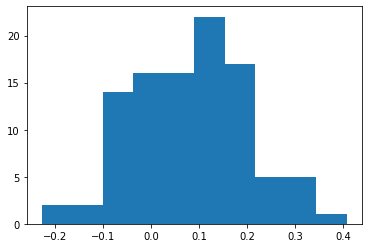

In [8]:
fig, ax = plt.subplots()
ax.hist(scores)

In [9]:
len(list(filter(lambda x: x > 0.2068, scores))) / len(scores)

0.12